# Challenge 07 - Margin Leakage in Clinical Supplies - Multi-Source Merging

Our finance team suspects that several high-usage medical products are driving volume but delivering little to no profit margin — or even losses. We’ve observed inconsistencies between usage patterns and expected cost efficiency across several EU countries.

You’ve been given two datasets:

retail_clinical.csv: A transaction-level export of medical product usage (e.g. units billed during clinical operations across 5 countries)
products_clinical.csv: A reference product file that includes product category and base cost per unit

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

## Data loading

In [158]:
products_df = pd.read_csv('../data/products_clinical.csv')
retail_df = pd.read_csv('../data/retail_clinical.csv')

In [159]:
# Merge product info into retail data
products_retail_df = retail_df.merge(products_df, on='ProductID', how='left')

# Check for structural or data integrity issues
print('Null values in key columns after merge:')
print(products_retail_df[['ProductID', 'ProductName', 'BaseCost', 'Category']].isnull().sum())

print('\nDataFrame structure overview:')
products_retail_df.info()

assert products_retail_df['BaseCost'].notna().all(), ' BaseCost has missing values after merge'
assert products_retail_df['Category'].notna().all(), ' Category is missing for some products'
assert products_retail_df['ProductName'].notna().all(), ' ProductName is missing'
assert (len(products_retail_df)) == (len(retail_df)), 'Row count mismatch — merge dropped or duplicated rows'

Null values in key columns after merge:
ProductID      0
ProductName    0
BaseCost       0
Category       0
dtype: int64

DataFrame structure overview:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    200 non-null    int64  
 1   ProductID    200 non-null    object 
 2   Quantity     200 non-null    int64  
 3   UnitPrice    200 non-null    float64
 4   InvoiceDate  200 non-null    object 
 5   Country      200 non-null    object 
 6   ProductName  200 non-null    object 
 7   Category     200 non-null    object 
 8   BaseCost     200 non-null    float64
dtypes: float64(2), int64(2), object(5)
memory usage: 15.6+ KB


## Metric engineering

In [160]:
# Revenue, Cost, and Margin calculation
products_retail_df['Revenue'] = products_retail_df['Quantity'] * products_retail_df['UnitPrice']
products_retail_df['Cost'] = products_retail_df['Quantity'] * products_retail_df['BaseCost']
products_retail_df['Margin'] = products_retail_df['Revenue'] - products_retail_df['Cost']

In [161]:
products_retail_df[['Revenue', 'Cost', 'Margin']].describe()

,Revenue,Cost,Margin
count,200.00000,200.000000,200.000000
mean,520.44585,180.055000,340.390850
std,456.03692,217.477434,412.056409
min,3.61000,1.000000,-525.920000
25%,125.82750,25.000000,30.362500
50%,382.69000,100.000000,197.880000
75%,838.88250,250.000000,599.832500
max,1746.36000,950.000000,1626.590000


In [162]:
assert 'Margin' in products_retail_df.columns
assert products_retail_df['Margin'].notna().all()

### Grouping and summarising

In [163]:
# Product summary
product_summary = (
    products_retail_df
    .groupby("ProductName")[["Quantity", "Revenue", "Cost", "Margin"]]
    .sum()
    .reset_index()
)
product_summary

,ProductName,Quantity,Revenue,Cost,Margin
0,Antiviral Medication,342,22754.49,17100.0,5654.49
1,COVID Vaccine Dose,384,20906.63,5760.0,15146.63
2,Insulin Pen,396,19898.49,9900.0,9998.49
3,Rapid Test Kit,354,17522.12,2832.0,14690.12
4,Surgical Mask,419,23007.44,419.0,22588.44


In [164]:
product_summary["MarginPerUnit"] = product_summary["Margin"] / product_summary["Quantity"]

### Flag Margin Leakage

In [165]:
top_10_products = product_summary.sort_values(by="Quantity", ascending=False).head(10)
top_10_products

,ProductName,Quantity,Revenue,Cost,Margin,MarginPerUnit
4,Surgical Mask,419,23007.44,419.0,22588.44,53.910358
2,Insulin Pen,396,19898.49,9900.0,9998.49,25.248712
1,COVID Vaccine Dose,384,20906.63,5760.0,15146.63,39.444349
3,Rapid Test Kit,354,17522.12,2832.0,14690.12,41.497514
0,Antiviral Medication,342,22754.49,17100.0,5654.49,16.533596


In [166]:
# Margin Leakage
margin_leakage = top_10_products[top_10_products["MarginPerUnit"] <= 0]
margin_leakage

,ProductName,Quantity,Revenue,Cost,Margin,MarginPerUnit


In [167]:
# Low margin leakage
low_margin_risk = top_10_products[top_10_products["MarginPerUnit"] < 0.5]
low_margin_risk

,ProductName,Quantity,Revenue,Cost,Margin,MarginPerUnit


In [168]:
leakage_candidates = product_summary[
    (product_summary["Quantity"] > 20) &
    (product_summary["MarginPerUnit"] <= 0)
]
leakage_candidates

,ProductName,Quantity,Revenue,Cost,Margin,MarginPerUnit


### Margin Analysis Summary
- Among the top 10 most-used products, all had positive margin per unit.
- No immediate margin leakage risk was detected.
- We recommend monitoring low-margin products like [X] or [Y] if costs increase.

## Visualisation

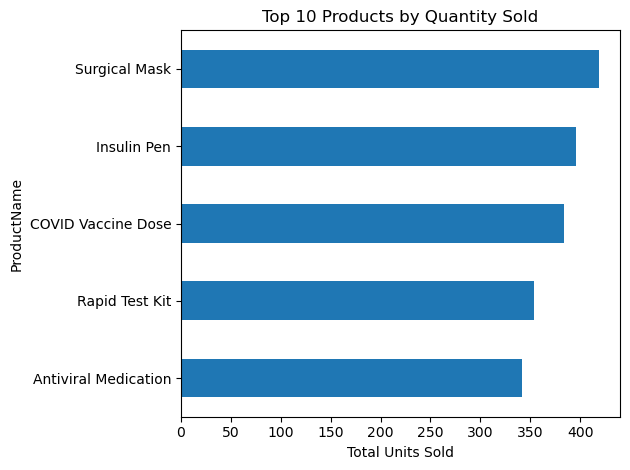

In [169]:
top_10_products.sort_values(by="Quantity", ascending=True).plot(
    kind="barh", x="ProductName", y="Quantity", legend=False,
    title="Top 10 Products by Quantity Sold"
)
plt.xlabel("Total Units Sold")
plt.tight_layout()
plt.show()

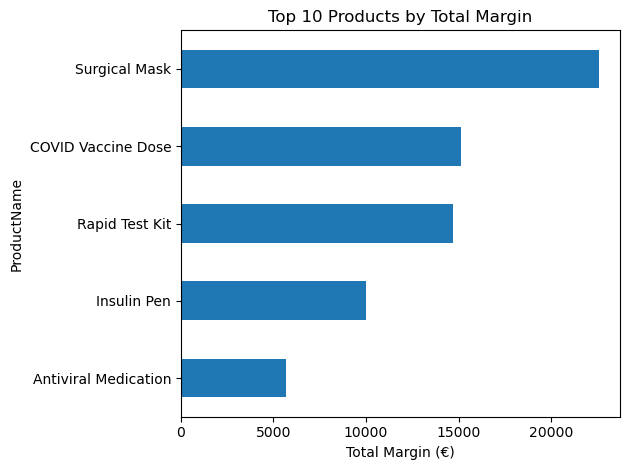

In [170]:
top_10_products.sort_values(by="Margin", ascending=True).plot(
    kind="barh", x="ProductName", y="Margin", legend=False,
    title="Top 10 Products by Total Margin"
)
plt.xlabel("Total Margin (€)")
plt.tight_layout()
plt.show()

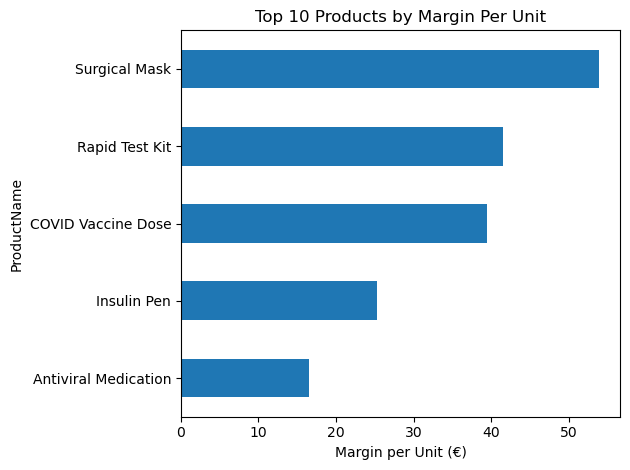

In [171]:
top_10_products.sort_values(by="MarginPerUnit", ascending=True).plot(
    kind="barh", x="ProductName", y="MarginPerUnit", legend=False,
    title="Top 10 Products by Margin Per Unit"
)
plt.xlabel("Margin per Unit (€)")
plt.tight_layout()
plt.show()

### Executive Summary – Margin Analysis

- **Surgical Masks** dominate across all three metrics:
  - Highest total quantity sold
  - Highest total margin
  - Highest margin per unit
- No margin leakage was detected among top-selling products.
- All high-usage items are currently profitable, with no product showing negative per-unit margins.

### Recommendations

- Continue strategy for Surgical Masks — current pricing is both competitive and profitable.
- Monitor lower-margin products such as Antiviral Medication for changes in cost or reimbursement rate.
- Expand margin analysis to long-tail products beyond top 10 to check for low-volume leakage.

In [ ]:
# function definition (practice)
def summarize_product_margins(retail_df, products_df, top_n=10):
    merged = retail_df.merge(products_df, on="ProductID", how="left")
    
    # Assertions
    assert len(merged) == len(retail_df), "Row count mismatch after merge"
    assert merged["BaseCost"].notna().all(), "Missing BaseCost values"
    
    # Metric engineering
    merged["Revenue"] = merged["Quantity"] * merged["UnitPrice"]
    merged["Cost"] = merged["Quantity"] * merged["BaseCost"]
    merged["Margin"] = merged["Revenue"] - merged["Cost"]
    merged["MarginPerUnit"] = merged["Margin"] / merged["Quantity"]
    
    # Grouped summary
    grouped = (
        merged.groupby("ProductName")[["Quantity", "Revenue", "Cost", "Margin"]]
        .sum()
        .reset_index()
    )
    grouped["MarginPerUnit"] = grouped["Margin"] / grouped["Quantity"]
    top_products = grouped.sort_values(by="Quantity", ascending=False).head(top_n)
    
    return top_products

top_10_products = summarize_product_margins(retail_df, products_df)